# Capstone Project - The Battle of the Neighborhoods
## Find the best place to open a restaurant - where would you recommend opening a restaurant in a particular city for a potential investor?

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Introduction</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Methodology</a>

4.  <a href="#item5">Results and Discussion</a>  
    
5.  <a href="#item5">Conclusion</a> 
    </font>
    </div>


## 1. Introduction <a name="introduction"></a>

### 1.1. Business problem

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Spanish restaurant** in **Madrid**, Spain.

Since there are lots of restaurants in Madrid we will try to detect **locations that are not already crowded with restaurants**.

**Madrid** is the capital of Spain, and is home to the Spanish Royal family as well as the Spanish Government. It is a modern metropolitan city and an economical and industrial center of Spain, and, with its population of nearly 3,5 million people, is also the biggest city in Spain. It is located in the centre of the Iberian Peninsula, and is surrounded by mountains and natural parks. Traditionally it the hub between different areas of Spain and is therefore connected to all major Spanish cities by train, road or air.

We will leverage the data science techniques to come up with a few recommended suggestions on the best neighborhoods and locations to enable the stakeholders to reach a final decision on the best location.

### 1.2. Target Audience

* A business entrepreneur looking into investing and opening up new restaurant in Madrid.
* Business Analyst or Data Scientists, looking to analyze the neighborhoods of Madrid using python, jupyter notebook and some machine learning techniques.
* Someone curious about data that want to have an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.

## 2. Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants in the neighbourhood (any type of restaurant)
* number of and distance to Spanish restaurants in the neighbourhood, if any

Following data sources will be needed to extract/generate the required information:
* wikipedia webpage containing all of Madrid city´s neighbourhood data
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

#### Importing relevant Python libraries for the Capstone project

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from urllib.request import urlopen # library for working with URLs

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install geocoder
import geocoder
!pip install geopandas
import geopandas as gpd
!pip install easydev --upgrade
!pip install colormap
from colormap import rgb2hex

!pip install shapely
from shapely import geometry
from shapely.geometry import shape, mapping, Point, Polygon, MultiPolygon, GeometryCollection

!pip install fiona
import fiona

!pip install --upgrade scikit-learn
!pip install yellowbrick
!pip install descartes
!pip install folium
import folium # map rendering library
from folium import plugins
!pip install branca
from branca.colormap import linear

!pip install pickle-mixin
import pickle

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

from sklearn import metrics 
from scipy.spatial.distance import cdist

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

#### Web scrape the Madrid wikipedia file and reformat it into an appropriate Pandas dataframe

Need to gather some preliminary information about the Madrid area such as district, neighourhood, etc...so the ideal place to look for this data is wikipedia

In [2]:
# extract from the Wikipedia webpage all 130 neighbourhoods of Madrid into Pandas dataframe
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid"
response = requests.get(url)
lines = response.content.decode('utf-8').splitlines()

len_lines = len(lines)

# datarow variables
dummy = "" # redundant variable
district_name = ""
number = ""
neighborhood = ""
postal_code = ""
latitude_val = ""
longitude_val = ""
start_index = 0
end_index = 0

# define the dataframe columns
column_names = ['District', 'Number', 'Neighborhood']

# instantiate the dataframe
madrid_data_wiki = pd.DataFrame(columns=column_names)

# loop through every line
for i in range(0, len_lines):
    line = lines[i]

    # extract the header columns data into headers array and
    if "</td></tr></tbody></table>" in line:
        dummy = ""
        break
    # append the datarow variables as entries into data array
    elif "</td></tr>" in line:
        # Retrieve the latitude and the longitude coordinates of each neighborhood
        if line.find("</tbody></table>") < 0 and neighborhood != "":
            if neighborhood == "Los Cármenes":
                index = neighborhood.find("Los ") + len("Los ")
                neighborhood = neighborhood[index:len(neighborhood)]
            madrid_data_wiki = madrid_data_wiki.append({'District': district_name,
                                                        'Number': number,
                                                        'Neighborhood': neighborhood}, ignore_index=True)
                                                        #'Postal Code': postal_code,
                                                        #'Latitude': latitude_val,
                                                        #'Longitude': longitude_val}, ignore_index=True)
    elif "<td rowspan=" in line:
        # extract district name
        if line.find(" title=") > -1:
            index = line.find(" title=") + len(" title=")
            rest = line[index:len(line)]
            if rest.find(">") > -1:
                index = rest.find(">") + len(">")
                rest = rest[index:len(rest)]
                if rest.find("<") > -1:
                    end_index = rest.find("<")
                    district_name = rest[0:end_index]
    elif "<td align=\"center\"><a href=" in line:
        # extract neighbourhood
        index = line.find("<td align=\"center\"><a href=") + len("<td align=\"center\"><a href=")
        rest = line[index:len(line)]
        if rest.find(" title=") > -1:
            index = rest.find(" title=") + len(" title=")
            rest = rest[index:len(line)]
            if rest.find(">") > -1:
                index = rest.find(">") + len(">")
                rest = rest[index:len(rest)]
                if rest.find("<") > -1:
                    end_index = rest.find("<")
                    neighborhood = rest[0:end_index]
    elif "<td align=\"center\">" in line:
        # extract district number
            if line.find("<td align=\"center\">") > -1 and line.find(" title=") < 0:
                start_index = line.find("<td align=\"center\">") + len("<td align=\"center\">")
                number = line[start_index:len(line)]
    else:
        dummy = ""

madrid_data_wiki

District Number                Neighborhood
0                 Centro     11                     Palacio
1                 Centro     12                 Embajadores
2                 Centro     13                      Cortes
3                 Centro     14                    Justicia
4                 Centro     15                 Universidad
..                   ...    ...                         ...
125  San Blas-Canillejas    208                 El Salvador
126              Barajas    211            Alameda de Osuna
127              Barajas    212                  Aeropuerto
128              Barajas    213  Casco Histórico de Barajas
129              Barajas    214                       Timón

[130 rows x 3 columns]

Gather Madrid shapefile and ancillary files for extracting Neighbourhood Polygon coordinates data
* Step 1 - download the Madrid GeoJson file containing all Polygon coordinates per Madrid neighbourhood via following url link: https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid.geojson
* Step 2 - convert GeoJson file into Shapefiles file format via https://mapshaper.org
* Step 3 - upload corresponding madrid.* files to Python kernel runtime to run this python code

In [3]:
# Read file from Shapefile
fp = "madrid.shp"
madrid_neighborhood_geodf = gpd.read_file(fp, encoding='utf-8')
madrid_neighborhood_geodf

name  cartodb_id                created_at  \
0                       Palacio           1  2013-12-02T07:16:22+0100   
1                   Embajadores           2  2013-12-02T07:16:22+0100   
2                        Cortes           3  2013-12-02T07:16:22+0100   
3                      Justicia           4  2013-12-02T07:16:22+0100   
4                   Universidad           5  2013-12-02T07:16:22+0100   
..                          ...         ...                       ...   
123            Alameda de Osuna         124  2013-12-02T07:16:22+0100   
124                  Aeropuerto         125  2013-12-02T07:16:22+0100   
125  Casco Histórico de Barajas         126  2013-12-02T07:16:22+0100   
126                       Timón         127  2013-12-02T07:16:22+0100   
127                  Corralejos         128  2013-12-02T07:16:22+0100   

                   updated_at  \
0    2013-12-02T07:16:22+0100   
1    2013-12-02T07:16:22+0100   
2    2013-12-02T07:16:22+0100   
3    2013-12-02T07:16:22+0100   
4    2013-12-02T07:16:22+0100   
..                        ...   
123  2013-12-02T07:16:22+0100   
124  2013-12-02T07:16:22+0100   
125  2013-12-02T07:16:22+0100   
126  2013-12-02T07:16:22+0100   
127  2013-12-02T07:16:22+0100   

                                              geometry  
0    POLYGON ((-3.70462 40.42147, -3.70503 40.42135...  
1    POLYGON ((-3.70262 40.41549, -3.70155 40.41510...  
2    POLYGON ((-3.69178 40.42052, -3.69166 40.42006...  
3    POLYGON ((-3.69836 40.42094, -3.69836 40.42094...  
4    POLYGON ((-3.70028 40.42119, -3.70353 40.42144...  
..                                                 ...  
123  POLYGON ((-3.59194 40.45123, -3.59194 40.45123...  
124  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  
125  POLYGON ((-3.58094 40.46887, -3.58026 40.46997...  
126  POLYGON ((-3.57958 40.48115, -3.58059 40.47826...  
127  POLYGON ((-3.58094 40.46887, -3.58120 40.46824...  

[128 rows x 5 columns]

In [4]:
madrid_neighborhood = madrid_neighborhood_geodf[['name', 'geometry']].copy()
madrid_neighborhood.columns = ('Neighborhood', 'Geometry')
madrid_neighborhood['Neighborhood'] = madrid_neighborhood_geodf['name'].str.title()
madrid_neighborhood.tail()

Neighborhood  \
123            Alameda De Osuna   
124                  Aeropuerto   
125  Casco Histórico De Barajas   
126                       Timón   
127                  Corralejos   

                                              Geometry  
123  POLYGON ((-3.59194 40.45123, -3.59194 40.45123...  
124  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  
125  POLYGON ((-3.58094 40.46887, -3.58026 40.46997...  
126  POLYGON ((-3.57958 40.48115, -3.58059 40.47826...  
127  POLYGON ((-3.58094 40.46887, -3.58120 40.46824...

In [5]:
from shapely.wkt import loads as load_wkt

centroid_list = []

for polygon in madrid_neighborhood_geodf["geometry"]:
    box_str = str(polygon)
    p1 = load_wkt(box_str)
    point = p1.centroid
#     print(type(p1.centroid.x))
#     print(p1.centroid.y)
    centroid_list.append((p1.centroid.y, p1.centroid.x))

lat_centr, lon_centr = zip(*centroid_list)

madrid_neighborhood['Latitude'] = lat_centr
madrid_neighborhood['Longitude'] = lon_centr

Let's create the final input dataset

In [6]:
df_madrid_complete = madrid_neighborhood
df_madrid_complete.head()

Neighborhood                                           Geometry   Latitude  \
0      Palacio  POLYGON ((-3.70462 40.42147, -3.70503 40.42135...  40.416600   
1  Embajadores  POLYGON ((-3.70262 40.41549, -3.70155 40.41510...  40.410419   
2       Cortes  POLYGON ((-3.69178 40.42052, -3.69166 40.42006...  40.416025   
3     Justicia  POLYGON ((-3.69836 40.42094, -3.69836 40.42094...  40.424839   
4  Universidad  POLYGON ((-3.70028 40.42119, -3.70353 40.42144...  40.426850   

   Longitude  
0  -3.712763  
1  -3.701153  
2  -3.695522  
3  -3.695351  
4  -3.705760

## 3. Methodology <a name="methodology"></a>

### 3.1 Business Understanding

The aim of this project is to find the best neighborhood of Madrid to open a new restaurant.

### 3.2 Analytical Approach

There are a total of 130 neighborhoods in Madrid so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant. Briefly, after some steps of Data Cleaning and Data Exploration, I will use a K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.

### 3.3 Analytical Approach

Will be adopting “Folium” a python library for exploring data that can create interactive leaflet map using coordinate data.

Use geopy library to get the latitude and longitude values of Madrid City.

In [7]:
address = 'Madrid, Spain'

geolocator = Nominatim(user_agent="mad_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid City are 40.4167047, -3.7035825.


Now it's time to use the foursquare API to examinate Madrid city

In [8]:
CLIENT_ID = '4LJS4VEZUOLAZ350STJAD43WKIVBFXYONC22AVB0UQI3GGOM' # your Foursquare ID
CLIENT_SECRET = '0TDZ4MMLTKENSDANCCRBRGUGMZCYBB1CHJNAZIXUGF2QYPFC' # your Foursquare Secret
ACCESS_TOKEN = 'SXDX1VFQBLANOQFXFOSWE2AC5FNXN3UUSZEL3DE41CJ3J2OJ' # your FourSquare Access Token
VERSION = '20200605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Extract venues for each neighborhood in Madrid in the 'food' category, we will take later about filtering the relevant sub-categories of food data as not all of these are relevant for this analysis e.g. coffee shops, pizza places, bakeries etc. are not direct competitors so we don't care about those.
Mostly concerned about gathering information about Spanish restaurants in the neighbourhood.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    
    print('Obtaining venues around candidate locations:', end='')
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(            
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]

        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        print(' .', end='')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Category']

    print(' done.')    
    return(nearby_venues)

In [10]:
# Try to load from local file system in case we did this before
madrid_venues = []
loaded = False
try:
    with open('madrid_venues.pkl', 'rb') as f:
        madrid_venues = pickle.load(f)
    loaded = True

    # explode venues list into rows and columns in a Pandas dataframe for data manipulation
    madrid_venues = pd.DataFrame(data=madrid_venues, 
                                 columns=['Neighborhood', 
                                          'Neighborhood Latitude', 
                                          'Neighborhood Longitude', 
                                          'Venue',
                                          'Venue Latitude', 
                                          'Venue Longitude',
                                          'Venue Category'])

    df1 = pd.DataFrame(data=madrid_venues['Neighborhood'], columns=['Neighborhood'])
    df2 = pd.DataFrame(data=madrid_venues['Neighborhood Latitude'], columns=['Neighborhood Latitude'])
    df3 = pd.DataFrame(data=madrid_venues['Neighborhood Longitude'], columns=['Neighborhood Longitude'])
    df4 = pd.DataFrame(data=madrid_venues['Venue'], columns=['Venue'])
    df5 = pd.DataFrame(data=madrid_venues['Venue Latitude'], columns=['Venue Latitude'])
    df6 = pd.DataFrame(data=madrid_venues['Venue Longitude'], columns=['Venue Longitude'])
    df7 = pd.DataFrame(data=madrid_venues['Venue Category'], columns=['Venue Category'])
    dfs = [df1, df2, df3, df4, df5, df6, df7] # list of dataframes
 
    madrid_venues = pd.concat(dfs, axis=1)
    print('Madrid venues data loaded via local file system.')
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    #run to extract nearby venues on every neighborhood and create a new dataframe called madrid_venues.
    madrid_venues = getNearbyVenues(names=df_madrid_complete['Neighborhood'],
                                    latitudes=df_madrid_complete['Latitude'],
                                    longitudes=df_madrid_complete['Longitude'],
                                    #radius=1500)
                                    radius=1000)
    
    # Let's persists this in local file system
    with open('madrid_venues.pkl', 'wb') as f:
        pickle.dump(madrid_venues, f)
    print('Madrid venues data loaded via Foursquare API.')

Madrid venues data loaded via local file system.


Ok gathered generic set of food venues opened in Madrid

In [11]:
print(madrid_venues.shape)
madrid_venues.head()

(6296, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Palacio                40.4166               -3.712763   
1      Palacio                40.4166               -3.712763   
2      Palacio                40.4166               -3.712763   
3      Palacio                40.4166               -3.712763   
4      Palacio                40.4166               -3.712763   

                       Venue  Venue Latitude  Venue Longitude  \
0  la gastroteca de santiago       40.416639        -3.710944   
1        La Esquina del Real       40.417356        -3.710364   
2            Café de Oriente       40.418081        -3.711867   
3          Charlie Champagne       40.413936        -3.712647   
4                  Gyoza Go!       40.416179        -3.708612   

        Venue Category  
0           Restaurant  
1    French Restaurant  
2   Spanish Restaurant  
3           Restaurant  
4  Dumpling Restaurant

In [12]:
rest_unique = madrid_venues.groupby(['Venue',
                                     'Venue Latitude', 
                                     'Venue Longitude',
                                     'Venue Category']).size().reset_index(name='Counts') 
print(rest_unique.shape)
rest_unique.head(10)

(3200, 5)


Venue  Venue Latitude  Venue Longitude  Venue Category  Counts
0        (H)arina       40.446962        -3.694539          Bakery       2
1  100 Montaditos       40.347108        -3.677199  Sandwich Place       1
2  100 Montaditos       40.363294        -3.739031  Sandwich Place       1
3  100 Montaditos       40.381375        -3.663684  Sandwich Place       2
4  100 Montaditos       40.386003        -3.763597  Sandwich Place       1
5  100 Montaditos       40.393706        -3.796434  Sandwich Place       1
6  100 Montaditos       40.395526        -3.663918  Sandwich Place       2
7  100 Montaditos       40.404233        -3.609993  Sandwich Place       1
8  100 Montaditos       40.406980        -3.670893  Sandwich Place       2
9  100 Montaditos       40.411660        -3.658264  Sandwich Place       2

The foursquare API can help me to find a lot of places easily but if I use two centroids that are too close, I could extract duplicates venues.

To solve this problem, I will link a unique venue with the right neighborhood using his polygon ("geometry")

In [13]:
rest_list = []

for ind1, rest in rest_unique.iterrows():
    point = Point(rest[["Venue Longitude"]].item(), rest[["Venue Latitude"]].item())
    for ind2, neighborhood in df_madrid_complete.iterrows():
        polygon = shape(neighborhood[["Geometry"]].item())

        if (polygon.contains(point)):
            frame = {'Neighborhood': neighborhood[["Neighborhood"]].item(),
                     'Neighborhood Latitude': neighborhood[["Latitude"]].item(),
                     'Neighborhood Longitude': neighborhood[["Longitude"]].item(),
                     'Venue': rest[["Venue"]].item(), 
                     #'Venue': s, 
                     'Venue Latitude': rest[["Venue Latitude"]].item(), 
                     'Venue Longitude': rest[["Venue Longitude"]].item(),
                     'Venue Category': rest[["Venue Category"]].item()
                    }
            rest_list.append(frame)
            break

cn = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
      'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
madrid_venues_unique = pd.DataFrame(rest_list, columns = cn)
madrid_venues_unique.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Rios Rosas              40.443574               -3.696422   
1         Butarque              40.338369               -3.674994   
2       Buenavista              40.368278               -3.744770   
3  Palomeras Bajas              40.385940               -3.657573   
4          Aguilas              40.382983               -3.769777   

            Venue  Venue Latitude  Venue Longitude  Venue Category  
0        (H)arina       40.446962        -3.694539          Bakery  
1  100 Montaditos       40.347108        -3.677199  Sandwich Place  
2  100 Montaditos       40.363294        -3.739031  Sandwich Place  
3  100 Montaditos       40.381375        -3.663684  Sandwich Place  
4  100 Montaditos       40.386003        -3.763597  Sandwich Place

I have managed to remove a lot of duplicates, by half, as you can see from the below:

In [14]:
print(madrid_venues.shape)
print(madrid_venues_unique.shape)

(6296, 7)
(3182, 7)


Now let's see all the points in a map:

In [106]:
rest_map = folium.Map([latitude, longitude], zoom_start=11)

for label, lat, lng in zip(madrid_venues_unique['Venue'], 
                           madrid_venues_unique['Venue Latitude'], 
                           madrid_venues_unique['Venue Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        colur='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False
    ).add_to(rest_map)

from IPython.display import display
display(rest_map)

Let's use all the info we have to prepare the final dataset

In [15]:
madrid_onehot = pd.get_dummies(madrid_venues_unique['Venue Category'], prefix="", prefix_sep="")
madrid_onehot.insert(loc=0, column='Neighborhood', value=madrid_venues_unique['Neighborhood'])

#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped.head()

Neighborhood  American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0     Abrantes             0.000000               0.0                     0.0   
1      Acacias             0.000000               0.0                     0.0   
2      Adelfas             0.000000               0.0                     0.0   
3   Aeropuerto             0.000000               0.0                     0.0   
4      Aguilas             0.027027               0.0                     0.0   

   Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  Bistro  \
0          0.000000   0.000000         0.0  0.125000     0.0   
1          0.047619   0.000000         0.0  0.023810     0.0   
2          0.052632   0.000000         0.0  0.052632     0.0   
3          0.000000   0.076923         0.0  0.153846     0.0   
4          0.000000   0.000000         0.0  0.027027     0.0   

   Brazilian Restaurant  ...  Taco Place  Tapas Restaurant  Taverna  \
0                 0.125  ...     0.00000          0.000000      0.0   
1                 0.000  ...     0.02381          0.095238      0.0   
2                 0.000  ...     0.00000          0.105263      0.0   
3                 0.000  ...     0.00000          0.076923      0.0   
4                 0.000  ...     0.00000          0.135135      0.0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0              0.0           0.00000                 0.0              0.0   
1              0.0           0.02381                 0.0              0.0   
2              0.0           0.00000                 0.0              0.0   
3              0.0           0.00000                 0.0              0.0   
4              0.0           0.00000                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Venezuelan Restaurant  Vietnamese Restaurant  
0                            0.0                    0.0                    0.0  
1                            0.0                    0.0                    0.0  
2                            0.0                    0.0                    0.0  
3                            0.0                    0.0                    0.0  
4                            0.0                    0.0                    0.0  

[5 rows x 92 columns]

As explained in the earlier sections above, we are only interested about restaurants so I need to select only those rows. The stakeholders are not interested in looking to opening a new cafe or a bakery shop

In [16]:
# Select only the rows about restaurants.
# I suppose that our stakeholders doesn't looking to open a caffè or a bakery shop
madrid_grouped = madrid_grouped[['Neighborhood', 'Italian Restaurant', 
                                 'Pizza Place', 'Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Sandwich Place', 'Sushi Restaurant', 
                                 'Chinese Restaurant', 'Bistro', 'Burger Joint', 'Asian Restaurant', 'Diner', 'Vegetarian / Vegan Restaurant', 'Kebab Restaurant', 
                                 'Breakfast Spot', 'Steakhouse', 'Mediterranean Restaurant', 'Gastropub', 'Fast Food Restaurant', 'Food Court', 'Indian Restaurant', 
                                 'Food Truck', 'Noodle House', 'Argentinian Restaurant', 'Ramen Restaurant', 'American Restaurant', 'Middle Eastern Restaurant', 'Fried Chicken Joint', 
                                 'Greek Restaurant', 'Korean Restaurant', 'Mexican Restaurant', 'Falafel Restaurant', 
                                 'Salad Place', 'Spanish Restaurant'
                                ]]

madrid_grouped.head()

Neighborhood  Italian Restaurant  Pizza Place  Restaurant  \
0     Abrantes            0.000000     0.125000    0.000000   
1      Acacias            0.000000     0.119048    0.071429   
2      Adelfas            0.000000     0.000000    0.052632   
3   Aeropuerto            0.076923     0.000000    0.153846   
4      Aguilas            0.054054     0.027027    0.135135   

   Japanese Restaurant  Seafood Restaurant  Sandwich Place  Sushi Restaurant  \
0                  0.0            0.000000        0.125000           0.00000   
1                  0.0            0.000000        0.000000           0.02381   
2                  0.0            0.000000        0.052632           0.00000   
3                  0.0            0.000000        0.076923           0.00000   
4                  0.0            0.027027        0.054054           0.00000   

   Chinese Restaurant  Bistro  ...  Ramen Restaurant  American Restaurant  \
0            0.000000     0.0  ...               0.0             0.000000   
1            0.047619     0.0  ...               0.0             0.000000   
2            0.052632     0.0  ...               0.0             0.000000   
3            0.000000     0.0  ...               0.0             0.000000   
4            0.054054     0.0  ...               0.0             0.027027   

   Middle Eastern Restaurant  Fried Chicken Joint  Greek Restaurant  \
0                        0.0                  0.0               0.0   
1                        0.0                  0.0               0.0   
2                        0.0                  0.0               0.0   
3                        0.0                  0.0               0.0   
4                        0.0                  0.0               0.0   

   Korean Restaurant  Mexican Restaurant  Falafel Restaurant  Salad Place  \
0           0.000000                 0.0                 0.0          0.0   
1           0.000000                 0.0                 0.0          0.0   
2           0.052632                 0.0                 0.0          0.0   
3           0.000000                 0.0                 0.0          0.0   
4           0.000000                 0.0                 0.0          0.0   

   Spanish Restaurant  
0            0.125000  
1            0.238095  
2            0.157895  
3            0.076923  
4            0.081081  

[5 rows x 35 columns]

This function return the most common venues for each row

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Extract the top-10 venues for every neighborhood

In [18]:
# create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
madrid_venues_sorted = pd.DataFrame(columns=columns)
madrid_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    madrid_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

madrid_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0     Abrantes    Spanish Restaurant          Burger Joint   
1      Acacias    Spanish Restaurant           Pizza Place   
2      Adelfas    Spanish Restaurant        Breakfast Spot   
3   Aeropuerto            Restaurant                 Diner   
4      Aguilas            Restaurant    Spanish Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place  Fast Food Restaurant        Sandwich Place   
1            Restaurant  Fast Food Restaurant    Chinese Restaurant   
2            Restaurant     Korean Restaurant        Sandwich Place   
3    Spanish Restaurant        Breakfast Spot        Sandwich Place   
4  Fast Food Restaurant        Sandwich Place    Chinese Restaurant   

  6th Most Common Venue          7th Most Common Venue  \
0      Kebab Restaurant  Vegetarian / Vegan Restaurant   
1      Asian Restaurant               Sushi Restaurant   
2      Asian Restaurant           Fast Food Restaurant   
3    Italian Restaurant            Fried Chicken Joint   
4          Burger Joint             Italian Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                      Diner      Asian Restaurant     Chinese Restaurant  
1               Burger Joint        Breakfast Spot             Steakhouse  
2         Chinese Restaurant           Pizza Place    Japanese Restaurant  
3  Middle Eastern Restaurant           Pizza Place     Falafel Restaurant  
4           Kebab Restaurant           Pizza Place     Seafood Restaurant

In [19]:
madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

In [20]:
madrid_grouped_clustering.head(5)

Italian Restaurant  Pizza Place  Restaurant  Japanese Restaurant  \
0            0.000000     0.125000    0.000000                  0.0   
1            0.000000     0.119048    0.071429                  0.0   
2            0.000000     0.000000    0.052632                  0.0   
3            0.076923     0.000000    0.153846                  0.0   
4            0.054054     0.027027    0.135135                  0.0   

   Seafood Restaurant  Sandwich Place  Sushi Restaurant  Chinese Restaurant  \
0            0.000000        0.125000           0.00000            0.000000   
1            0.000000        0.000000           0.02381            0.047619   
2            0.000000        0.052632           0.00000            0.052632   
3            0.000000        0.076923           0.00000            0.000000   
4            0.027027        0.054054           0.00000            0.054054   

   Bistro  Burger Joint  ...  Ramen Restaurant  American Restaurant  \
0     0.0      0.125000  ...               0.0             0.000000   
1     0.0      0.023810  ...               0.0             0.000000   
2     0.0      0.000000  ...               0.0             0.000000   
3     0.0      0.000000  ...               0.0             0.000000   
4     0.0      0.054054  ...               0.0             0.027027   

   Middle Eastern Restaurant  Fried Chicken Joint  Greek Restaurant  \
0                        0.0                  0.0               0.0   
1                        0.0                  0.0               0.0   
2                        0.0                  0.0               0.0   
3                        0.0                  0.0               0.0   
4                        0.0                  0.0               0.0   

   Korean Restaurant  Mexican Restaurant  Falafel Restaurant  Salad Place  \
0           0.000000                 0.0                 0.0          0.0   
1           0.000000                 0.0                 0.0          0.0   
2           0.052632                 0.0                 0.0          0.0   
3           0.000000                 0.0                 0.0          0.0   
4           0.000000                 0.0                 0.0          0.0   

   Spanish Restaurant  
0            0.125000  
1            0.238095  
2            0.157895  
3            0.076923  
4            0.081081  

[5 rows x 34 columns]

### 3.4 Clustering

To address the problem of opening up a new restaurant and to perform analysis on the neighbourhood data such as in the Madrid city area in this project, I shall be using K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). 

The goal of this algorithm is to find groups in the data, with the number of groups or clusters represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

Do the initial step is to identify the best optimal value “K” using a famous analytical approach: the elbow method.

So let's proceed:

### Elbow method

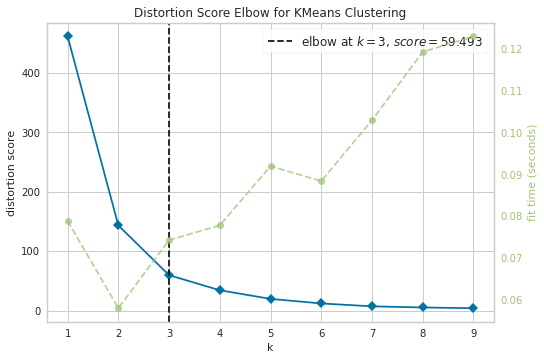

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(madrid_grouped_clustering)  # Fit the data to the visualizer
visualizer.poof()                          # Draw/show/poof the data

From the plot up here, I can deduce that the best K is **2**.
But before running the kmeans algorithm, let us try validate that indeed this is the best K value through some other evaluation methods or approaches.
For instance, let us test this with normal inertia to calculate elbow as follows:

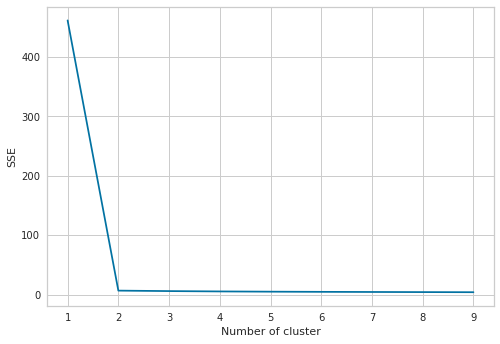

In [24]:
sse = {} 

for k in range(1, 10): 
    kmeans = KMeans(n_clusters=k).fit(madrid_grouped_clustering) 
    madrid_grouped_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

# Inertia: Sum of distances of samples to their plt.figure() 
plt.plot(list(sse.keys()), list(sse.values())) 
plt.xlabel("Number of cluster") 
plt.ylabel("SSE") 
plt.show()

As you can see, it reconfirms a similar result i.e. k = 2
From the above plots, is it now time to run the kmeans algorithm:

In [25]:
# Run k-means to cluster the neighborhood into 6 clusters
# set number of clusters
kclusters = 2

#madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int32)

Add clustering labels

In [26]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# madrid_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)
madrid_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Merge with df_madrid_complete to obtain the final result

In [27]:
# merge madrid_grouped with madrid_data_wiki to add latitude/longitude for each neighborhood
madrid_merged = df_madrid_complete.join(madrid_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
madrid_merged['Cluster Labels'] = madrid_merged['Cluster Labels'].fillna(0)
madrid_merged['Cluster Labels'] = madrid_merged['Cluster Labels'].astype(int)
madrid_merged.drop(columns='Geometry', inplace=True)
madrid_merged.head() # check the last columns!

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0      Palacio  40.416600  -3.712763               0    Spanish Restaurant   
1  Embajadores  40.410419  -3.701153               0    Spanish Restaurant   
2       Cortes  40.416025  -3.695522               0            Restaurant   
3     Justicia  40.424839  -3.695351               0            Restaurant   
4  Universidad  40.426850  -3.705760               1            Restaurant   

  2nd Most Common Venue          3rd Most Common Venue  \
0            Restaurant  Vegetarian / Vegan Restaurant   
1            Restaurant             Italian Restaurant   
2    Spanish Restaurant             Seafood Restaurant   
3    Spanish Restaurant                         Bistro   
4    Spanish Restaurant                      Gastropub   

      4th Most Common Venue          5th Most Common Venue  \
0                 Gastropub               Ramen Restaurant   
1            Breakfast Spot                    Pizza Place   
2  Mediterranean Restaurant                 Breakfast Spot   
3       American Restaurant             Italian Restaurant   
4               Pizza Place  Vegetarian / Vegan Restaurant   

      6th Most Common Venue     7th Most Common Venue 8th Most Common Venue  \
0       Japanese Restaurant                    Bistro          Burger Joint   
1  Mediterranean Restaurant        Seafood Restaurant      Sushi Restaurant   
2    Argentinian Restaurant       Japanese Restaurant      Sushi Restaurant   
3  Mediterranean Restaurant               Pizza Place        Sandwich Place   
4        Italian Restaurant  Mediterranean Restaurant   Japanese Restaurant   

    9th Most Common Venue         10th Most Common Venue  
0  Argentinian Restaurant       Mediterranean Restaurant  
1                  Bistro  Vegetarian / Vegan Restaurant  
2        Asian Restaurant  Vegetarian / Vegan Restaurant  
3               Gastropub               Asian Restaurant  
4          Breakfast Spot                          Diner

## 4. Results and Discussion

Prior to analyzing all the clusters, let’s take a look on a folium map by creating a map of Madrid with neighborhoods superimposed on top:

In [28]:
# create map
print(latitude)
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    if np.isnan(cluster):
        cluster = 0
    else:
        cluster = int(cluster)

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

40.4167047


As we can see, each cluster belong to a color with different characteristics.
Red plots belong to Cluster 1 and purple ones to Cluster 2.

Let us examine the clusters

#### Cluster 1

In [98]:
madrid_cluster_1 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[list(range(0, madrid_merged.shape[1]))]]
madrid_cluster_1.head()

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0      Palacio  40.416600  -3.712763               0    Spanish Restaurant   
1  Embajadores  40.410419  -3.701153               0    Spanish Restaurant   
2       Cortes  40.416025  -3.695522               0            Restaurant   
3     Justicia  40.424839  -3.695351               0            Restaurant   
5          Sol  40.418492  -3.703244               0            Restaurant   

  2nd Most Common Venue          3rd Most Common Venue  \
0            Restaurant  Vegetarian / Vegan Restaurant   
1            Restaurant             Italian Restaurant   
2    Spanish Restaurant             Seafood Restaurant   
3    Spanish Restaurant                         Bistro   
5    Spanish Restaurant         Argentinian Restaurant   

      4th Most Common Venue     5th Most Common Venue  \
0                 Gastropub          Ramen Restaurant   
1            Breakfast Spot               Pizza Place   
2  Mediterranean Restaurant            Breakfast Spot   
3       American Restaurant        Italian Restaurant   
5        Italian Restaurant  Mediterranean Restaurant   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0       Japanese Restaurant                Bistro          Burger Joint   
1  Mediterranean Restaurant    Seafood Restaurant      Sushi Restaurant   
2    Argentinian Restaurant   Japanese Restaurant      Sushi Restaurant   
3  Mediterranean Restaurant           Pizza Place        Sandwich Place   
5               Pizza Place    Seafood Restaurant    Mexican Restaurant   

    9th Most Common Venue         10th Most Common Venue  
0  Argentinian Restaurant       Mediterranean Restaurant  
1                  Bistro  Vegetarian / Vegan Restaurant  
2        Asian Restaurant  Vegetarian / Vegan Restaurant  
3               Gastropub               Asian Restaurant  
5                  Bistro                   Burger Joint

In [99]:
df1 = madrid_cluster_1.groupby(['Neighborhood', '1st Most Common Venue']).size().reset_index(name='Counts')
df2 = madrid_cluster_1.groupby(['Neighborhood', '2nd Most Common Venue']).size().reset_index(name='Counts')
df3 = madrid_cluster_1.groupby(['Neighborhood', '3rd Most Common Venue']).size().reset_index(name='Counts')
df4 = madrid_cluster_1.groupby(['Neighborhood', '4th Most Common Venue']).size().reset_index(name='Counts')
df5 = madrid_cluster_1.groupby(['Neighborhood', '5th Most Common Venue']).size().reset_index(name='Counts')
df6 = madrid_cluster_1.groupby(['Neighborhood', '6th Most Common Venue']).size().reset_index(name='Counts')
df7 = madrid_cluster_1.groupby(['Neighborhood', '7th Most Common Venue']).size().reset_index(name='Counts')
df8 = madrid_cluster_1.groupby(['Neighborhood', '8th Most Common Venue']).size().reset_index(name='Counts')
df9 = madrid_cluster_1.groupby(['Neighborhood', '9th Most Common Venue']).size().reset_index(name='Counts')
df10 = madrid_cluster_1.groupby(['Neighborhood', '10th Most Common Venue']).size().reset_index(name='Counts')

In [100]:
# create a list holding the names of all the top-10 venue categories and corresponding totals from Cluster 1
venue_list = []
dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10] # list of dataframes
cols2 = ['Neighborhood', 'Venue Category', 'Count']

for df in dfs:
    df_len = df.shape[0]

    for row in range(df_len): # [0] number of row count whereas [1] gives number of col count
        vnbhd = df.iloc[row, 0] # nbhd
        vcat = df.iloc[row, 1] # venue category
        vcount = df.iloc[row, 2] # venue count

        try:
            tlist = list(zip(*venue_list))
            test_nbhd_df = pd.DataFrame(columns=['Neighborhood'], data=tlist[0]) # extracts data from 'Neighborhood' col
            search_nbhd_list = test_nbhd_df['Neighborhood'].tolist()
            test_vcat_df = pd.DataFrame(columns=['Venue Category'], data=tlist[1]) # extracts data from 'Venue Category' col
            search_vcat_list = test_vcat_df['Venue Category'].tolist()
            test_vlist = pd.DataFrame(columns=cols2, data=venue_list)

            try:
                #search for Neighbourhood item
                index = search_nbhd_list.index(vnbhd)

                try:
                    #search for Venue Category item
                    index = search_vcat_list.index(vcat)

                    venue_list[index][2] = test_vlist.iloc[index, 2] + vcount
                except ValueError:
                    venue_list.append([vnbhd, vcat, vcount])

                #venue_list[index][2] = venue_list.iloc[index, 2] + vcount
            except ValueError:
                venue_list.append([vnbhd, vcat, vcount])
        except IndexError:
                venue_list.append([vnbhd, vcat, vcount])

madrid_cluster_1_nbhd_pc = pd.DataFrame(columns = cols2, data=venue_list)
madrid_cluster_1_nbhd_pc = madrid_cluster_1_nbhd_pc.sort_values(by=['Count'], ascending=False)
madrid_cluster_1_nbhd_pc = madrid_cluster_1_nbhd_pc.groupby(['Neighborhood', 'Venue Category']).agg({'Count': 'sum'}).reset_index()
madrid_cluster_1_nbhd = pd.merge(df_madrid_complete,madrid_cluster_1_nbhd_pc,on='Neighborhood', how='outer')
madrid_cluster_1_nbhd.sort_values(by=['Neighborhood', 'Venue Category'], ascending=[True, True], inplace=True)
madrid_cluster_1_nbhd.dropna(inplace=True)
madrid_cluster_1_nbhd = madrid_cluster_1_nbhd.reset_index(drop=True)
madrid_cluster_1_nbhd.head()

Neighborhood                                           Geometry  \
0           Acacias  POLYGON ((-3.70124 40.40625, -3.70040 40.40513...   
1           Acacias  POLYGON ((-3.70124 40.40625, -3.70040 40.40513...   
2           Adelfas  POLYGON ((-3.67221 40.39550, -3.67221 40.39550...   
3           Adelfas  POLYGON ((-3.67221 40.39550, -3.67221 40.39550...   
4  Alameda De Osuna  POLYGON ((-3.59194 40.45123, -3.59194 40.45123...   

    Latitude  Longitude       Venue Category  Count  
0  40.402248  -3.705948          Pizza Place   59.0  
1  40.402248  -3.705948   Spanish Restaurant   12.0  
2  40.402297  -3.669665       Breakfast Spot   38.0  
3  40.402297  -3.669665   Spanish Restaurant    1.0  
4  40.457732  -3.590131  Fried Chicken Joint    2.0

Let us plot each venue category from **Cluster 1** into a Folium map based on the frequency size of establishment type guiding the potential investor about where to open up a new Spanish restaurant in this cluster.

In [101]:
# create map
nbhd_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

madrid_clust1 = madrid_cluster_1_nbhd.rename(columns={'Geometry':'geometry'})
folium.GeoJson(
                madrid_clust1,
                style_function = lambda x: {
                    'color': 'black',
                    'weight': 2.5,
                    'fillOpacity': 0
                },
                name='Departement').add_to(nbhd_map)
    
# add markers to the map
for poi, lat, lon, ven_cat, ven_count in zip(madrid_cluster_1_nbhd['Neighborhood'], madrid_cluster_1_nbhd['Latitude'], madrid_cluster_1_nbhd['Longitude'], madrid_cluster_1_nbhd['Venue Category'], madrid_cluster_1_nbhd['Count']):
    label = folium.Popup('Poi: ' + str(poi) + '; Category: ' + str(ven_cat))

    folium.CircleMarker(
        [lat, lon],
        radius=ven_count,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.7).add_to(nbhd_map)

display(nbhd_map)


#### Cluster 2

In [102]:
madrid_cluster_2 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[list(range(0, madrid_merged.shape[1]))]]
madrid_cluster_2.head()

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
4     Universidad  40.426850  -3.705760               1            Restaurant   
27  Ciudad Jardín  40.449477  -3.671695               1            Restaurant   
37     Gaztambide  40.436165  -3.713298               1    Spanish Restaurant   
43       El Pardo  40.554075  -3.766140               1            Restaurant   
46          Pilar  40.478334  -3.708268               1    Italian Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4     Spanish Restaurant             Gastropub           Pizza Place   
27    Spanish Restaurant  Fast Food Restaurant           Pizza Place   
37            Restaurant             Gastropub           Pizza Place   
43    Spanish Restaurant                Bistro        Breakfast Spot   
46  Fast Food Restaurant            Restaurant          Burger Joint   

            5th Most Common Venue          6th Most Common Venue  \
4   Vegetarian / Vegan Restaurant             Italian Restaurant   
27            Japanese Restaurant                   Burger Joint   
37                   Burger Joint             Italian Restaurant   
43               Kebab Restaurant  Vegetarian / Vegan Restaurant   
46                    Pizza Place             Spanish Restaurant   

       7th Most Common Venue          8th Most Common Venue  \
4   Mediterranean Restaurant            Japanese Restaurant   
27                     Diner  Vegetarian / Vegan Restaurant   
37       Japanese Restaurant             Seafood Restaurant   
43                     Diner               Asian Restaurant   
46          Kebab Restaurant            American Restaurant   

   9th Most Common Venue     10th Most Common Venue  
4         Breakfast Spot                      Diner  
27    Italian Restaurant  Middle Eastern Restaurant  
37        Sandwich Place         Chinese Restaurant  
43          Burger Joint         Chinese Restaurant  
46    Mexican Restaurant             Sandwich Place

In [103]:
df1 = madrid_cluster_2.groupby(['Neighborhood', '1st Most Common Venue']).size().reset_index(name='Counts')
df2 = madrid_cluster_2.groupby(['Neighborhood', '2nd Most Common Venue']).size().reset_index(name='Counts')
df3 = madrid_cluster_2.groupby(['Neighborhood', '3rd Most Common Venue']).size().reset_index(name='Counts')
df4 = madrid_cluster_2.groupby(['Neighborhood', '4th Most Common Venue']).size().reset_index(name='Counts')
df5 = madrid_cluster_2.groupby(['Neighborhood', '5th Most Common Venue']).size().reset_index(name='Counts')
df6 = madrid_cluster_2.groupby(['Neighborhood', '6th Most Common Venue']).size().reset_index(name='Counts')
df7 = madrid_cluster_2.groupby(['Neighborhood', '7th Most Common Venue']).size().reset_index(name='Counts')
df8 = madrid_cluster_2.groupby(['Neighborhood', '8th Most Common Venue']).size().reset_index(name='Counts')
df9 = madrid_cluster_2.groupby(['Neighborhood', '9th Most Common Venue']).size().reset_index(name='Counts')
df10 = madrid_cluster_2.groupby(['Neighborhood', '10th Most Common Venue']).size().reset_index(name='Counts')

In [104]:
# create a list holding the names of all the top-10 venue categories and corresponding totals from Cluster 2
venue_list = []
dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10] # list of dataframes
cols2 = ['Neighborhood', 'Venue Category', 'Count']

for df in dfs:
    df_len = df.shape[0]

    for row in range(df_len): # [0] number of row count whereas [1] gives number of col count
        vnbhd = df.iloc[row, 0] # nbhd
        vcat = df.iloc[row, 1] # venue category
        vcount = df.iloc[row, 2] # venue count

        try:
            tlist = list(zip(*venue_list))
            test_nbhd_df = pd.DataFrame(columns=['Neighborhood'], data=tlist[0]) # extracts data from 'Neighborhood' col
            search_nbhd_list = test_nbhd_df['Neighborhood'].tolist()
            test_vcat_df = pd.DataFrame(columns=['Venue Category'], data=tlist[1]) # extracts data from 'Venue Category' col
            search_vcat_list = test_vcat_df['Venue Category'].tolist()
            test_vlist = pd.DataFrame(columns=cols2, data=venue_list)

            try:
                #search for Neighbourhood item
                index = search_nbhd_list.index(vnbhd)

                try:
                    #search for Venue Category item
                    index = search_vcat_list.index(vcat)

                    venue_list[index][2] = test_vlist.iloc[index, 2] + vcount
                except ValueError:
                    venue_list.append([vnbhd, vcat, vcount])

                #venue_list[index][2] = venue_list.iloc[index, 2] + vcount
            except ValueError:
                venue_list.append([vnbhd, vcat, vcount])
        except IndexError:
                venue_list.append([vnbhd, vcat, vcount])

madrid_cluster_2_nbhd_pc = pd.DataFrame(columns = cols2, data=venue_list)
madrid_cluster_2_nbhd_pc = madrid_cluster_2_nbhd_pc.sort_values(by=['Count'], ascending=False)
madrid_cluster_2_nbhd_pc = madrid_cluster_2_nbhd_pc.groupby(['Neighborhood', 'Venue Category']).agg({'Count': 'sum'}).reset_index()
madrid_cluster_2_nbhd = pd.merge(df_madrid_complete,madrid_cluster_2_nbhd_pc,on='Neighborhood', how='outer')
madrid_cluster_2_nbhd.sort_values(by=['Neighborhood', 'Venue Category'], ascending=[True, True], inplace=True)
madrid_cluster_2_nbhd.dropna(inplace=True)
madrid_cluster_2_nbhd = madrid_cluster_2_nbhd.reset_index(drop=True)
madrid_cluster_2_nbhd.head()

Neighborhood                                           Geometry   Latitude  \
0     Abrantes  POLYGON ((-3.71625 40.38646, -3.71691 40.38450...  40.380159   
1   Aeropuerto  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  40.477296   
2   Aeropuerto  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  40.477296   
3   Aeropuerto  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  40.477296   
4      Aguilas  POLYGON ((-3.75800 40.38481, -3.75754 40.38441...  40.382983   

   Longitude             Venue Category  Count  
0  -3.724857         Spanish Restaurant   22.0  
1  -3.557254                      Diner   23.0  
2  -3.557254  Middle Eastern Restaurant    4.0  
3  -3.557254                 Restaurant   23.0  
4  -3.769777                 Restaurant    1.0

Let us plot each venue category from **Cluster 2** into a Folium map based on the frequency size of establishment type guiding the potential investor about where to open up a new Spanish restaurant in this cluster.

In [105]:
# create map
nbhd_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

madrid_clust2 = madrid_cluster_2_nbhd.rename(columns={'Geometry':'geometry'})
folium.GeoJson(
                madrid_clust2,
                style_function = lambda x: {
                    'color': 'black',
                    'weight': 2.5,
                    'fillOpacity': 0
                },
                name='Departement').add_to(nbhd_map)
    
# add markers to the map
for poi, lat, lon, ven_cat, ven_count in zip(madrid_cluster_2_nbhd['Neighborhood'], madrid_cluster_2_nbhd['Latitude'], madrid_cluster_2_nbhd['Longitude'], madrid_cluster_2_nbhd['Venue Category'], madrid_cluster_2_nbhd['Count']):
    label = folium.Popup('Poi: ' + str(poi) + '; Category: ' + str(ven_cat))

    folium.CircleMarker(
        [lat, lon],
        radius=ven_count,
        popup=label,
        color=rainbow[1],
        fill=True,
        fill_color=rainbow[1],
        fill_opacity=0.7).add_to(nbhd_map)

display(nbhd_map)


## 5. Conclusion

Our analysis shows that although there is a great number of restaurants in Madrid (~6300).

Created candidates and were then clustered to create zones of interest which contain greatest number of location candidates.

Result of all this is 130 neighbouhoods shown and split into two separate clusters in the above maps showing the size of the plots are directly proportionate to the frequency of the same type of restaurant establishment found in each neighbourhood. The idea behind this depiction is to help guide the potential investor about where to open up a new Spanish restaurant in this cluster taken into account of existing competition. These recommended areas or zones should therefore be considered only as a starting point for more detailed analysis.

This captstone project has attempted to show Madrid as an international city with many different types of new restaurant business to offer and I think we have gone through the process of identifying the business problem, specifying the data required, clean the datasets, performing a machine learning algorithm using k-means clustering and providing some useful tips to our stakeholder.

Perhaps as a recommended next step, is to perhaps contemplate using other clustering algorithms particularly DBSCAN to help isolate the less densely populated venue areas from the higher ones.